In [169]:
import numpy as np
import pandas as pd 

import re
import os


import umap
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from Bio import motifs
from Bio.Seq import Seq


import plotly.graph_objects as go
import plotly.express as px


In [2]:
lothar = '/home/enno/uni/SS24/thesis/02_seq_analysis'

In [3]:
if os.getcwd() == lothar:
    df = pd.read_csv('/home/enno/uni/SS24/thesis/01_data/hendecads/stretches_w_groups.csv').drop(columns=['Unnamed: 0'])
else:
    df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/0_data/npf_data/stretches_w_groups.csv').drop(columns=['Unnamed: 0'])

df['stretch_ix'] = df['stretch_ix'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

df.head()

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38


In [4]:
groups = df['group_id'].unique()
group_dict = {group: i for i, group in enumerate(groups)}

df['group_ix'] = df['group_id'].apply(lambda x: group_dict[x])
df

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,group_ix
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned,0
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned,0
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned,0
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42,1
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38,2
...,...,...,...,...,...,...,...
40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106,71
40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9,59
40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned,0
40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1,5


## Dictionaries and Utils

In [5]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

aa_dict = {'r': '+',
           'h': '+',
           'k': '+',
           'd': '-',
           'e': '-',
           's': 'polar',
           't': 'polar',
           'n': 'polar',
           'q': 'polar',
           'c': 'special',
           'u': 'special',
           'g': 'special',
           'p': 'special',
           'a': 'hydrophobic',
           'v': 'hydrophobic',
           'i': 'hydrophobic',
           'l': 'hydrophobic',
           'm': 'hydrophobic',
           'f': 'hydrophobic',
           'y': 'hydrophobic',
           'w': 'hydrophobic',
           'x': 'padding'}

aa_num_dict = {'r': 0,
               'h': 0,
               'k': 0,
               'd': 1,
               'e': 1,
               's': 2,
               't': 2,
               'n': 2,
               'q': 2,
               'c': 3,
               'u': 3,
               'g': 3,
               'p': 3,
               'a': 4,
               'v': 4,
               'i': 4,
               'l': 4,
               'm': 4,
               'f': 4,
               'y': 4,
               'w': 4,
               'x': 5}

color_dict = {'+': '#00A012',           # green  
              '-': '#D81B60',           # red
              'polar': '#FFC107',       # yellow
              'hydrophobic': '#1E88E5', # blue    
              'special': '#ADADAD',     # grey
              'padding': '#FFFFFF'}     # white 

color_num_dict = {0: '#00A012',           # green
                  1: '#D81B60',           # red
                  2: '#FFC107',           # yellow
                  3: '#1E88E5',           # blue
                  4: '#ADADAD',           # grey
                  5: '#FFFFFF'}           # white

In [6]:
# Letter code and color code for expected hendecad repeat
repeat = ['A', '*', '*', 'D', 'E', '*', '*', 'H', '*', '*', '*']
color_repeat = [color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['special']]

## Visual

In [7]:
def plot_eleven_repeat(seq_id, seq, n_shift=0, save=False):
    seq = seq[n_shift:]
    
    n = len(seq)
    q = n // 11
    r = n % 11

    positions = [repeat[i%11] for i in range(len(seq))]
    colors = [color_dict[aa_dict[aa]] for aa in seq]
    
    # pad last hendecad with padding color
    if n % 11 != 0:
        positions += ['x'] * (11 - r)
        colors += [color_dict['padding']] * (11 - r)
    
    fig, axes = plt.subplots(q+1, 1, figsize=(6, q/3))

    first = True
    for ax in axes:
        
        if first:
            ax.set_title(seq_id) 
            first = False
        
        ax.bar(np.arange(11), np.ones(11), color=colors[:11], edgecolor='black')
        ax.set_yticks([])
        ax.set_xticks([])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        colors = colors[11:]
        positions = positions[11:]

    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(repeat)

    legend_elements = [Patch(facecolor=color_dict[aa], edgecolor='black', label=aa) for aa in color_dict.keys()]
    plt.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.33, q-2))
    
    if save:
        plt.savefig(f'/home/enno/uni/SS23/thesis/seq_analysis/plots/{seq_id}.png', bbox_inches='tight')
        plt.clf()
    else:
        plt.show()

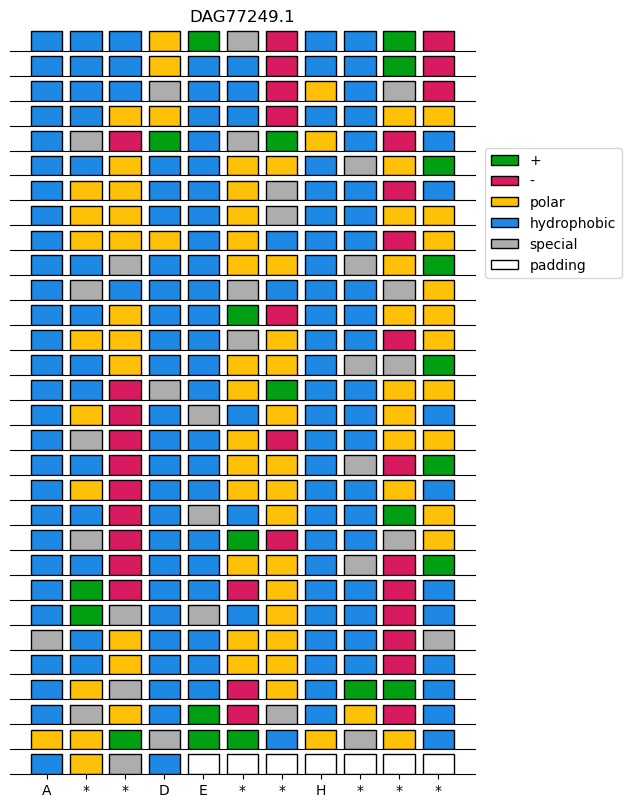

In [8]:
TMP = 'DAG77249.1'
MACH = 'WP_132310275.1'

plot_eleven_repeat(TMP, df[df['id'] == TMP]['stretch_seq'].values[0], n_shift=1)

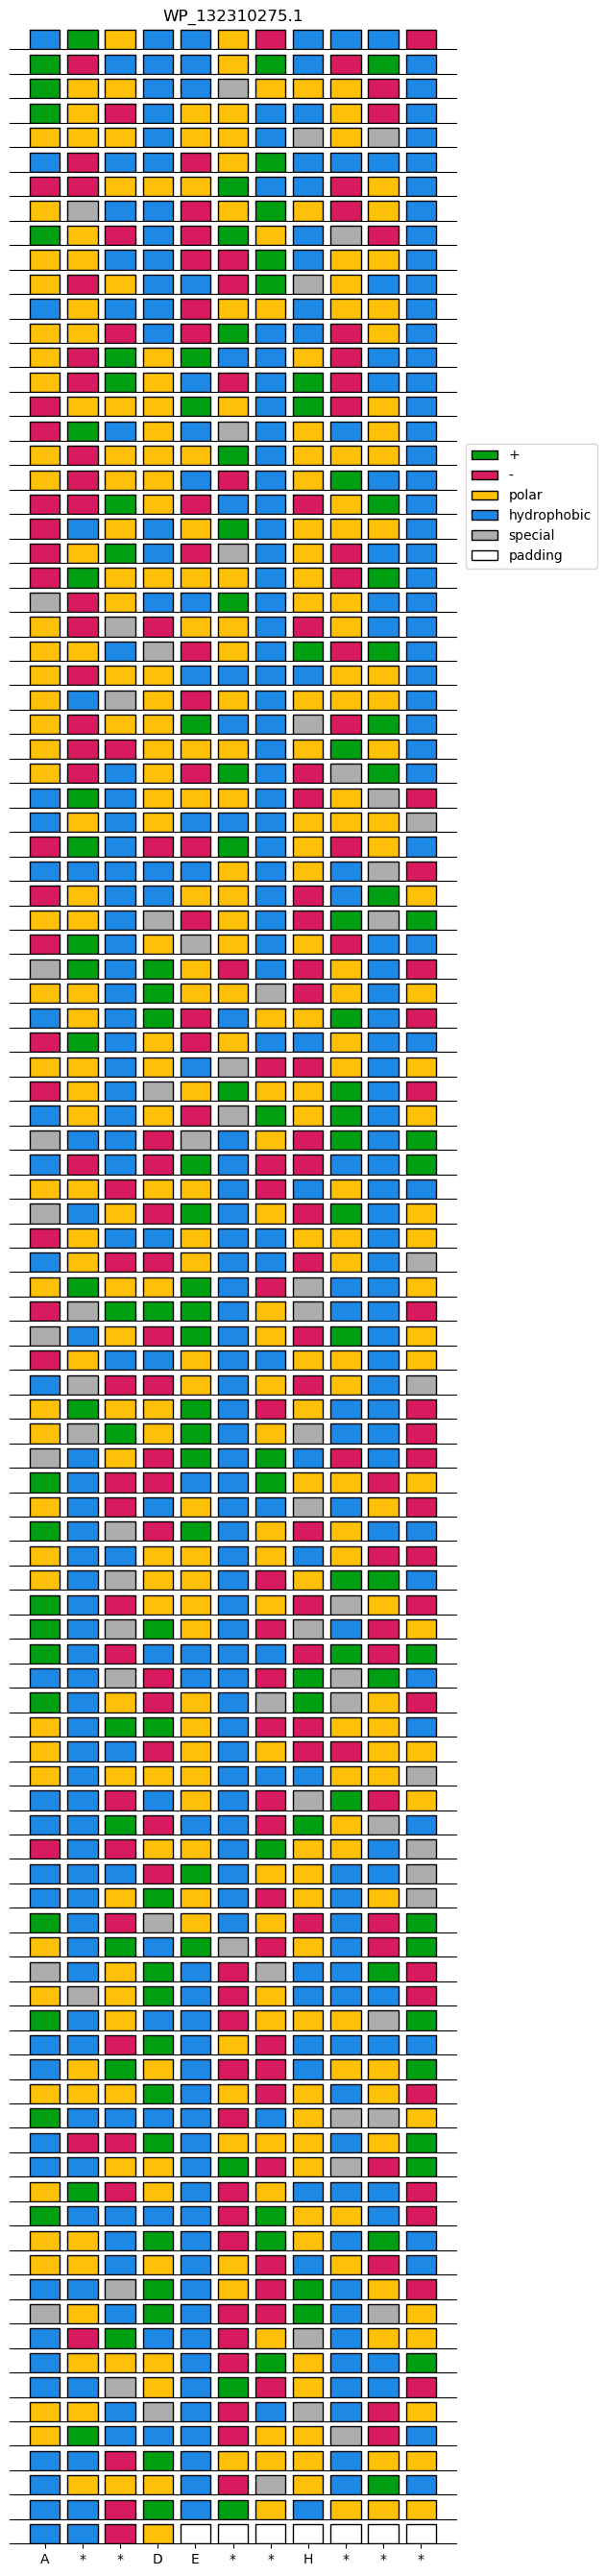

In [9]:
plot_eleven_repeat(MACH, df[df['id'] == MACH]['stretch_seq'].values[0])

## CLANS

In [170]:
if os.getcwd() == lothar:
    clans_data = "/home/enno/uni/SS24/thesis/01_data/hendecads/new_hendecads_1E-14.clans"
else:
    clans_data = "/ebio/abt1_share/prediction_hendecads/0_data/npf_data/clans_map/new_hendecads_1E-14.clans"  # '/home/enno/uni/SS23/thesis/data/hendecads/new_hendecads_1E-14.clans'  

with open(clans_data, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]
first_pos = 73772
last_pos = 73772 + 36455

pos = [x.split() for x in data[first_pos:last_pos]]

pos_df = pd.DataFrame(pos, columns=['id', 'x', 'y', '_'])

pos_df['x'] = pos_df['x'].astype(float)
pos_df['y'] = pos_df['y'].astype(float)

pos_df['group'] = df.drop_duplicates(subset='id').reset_index(drop=True)['group_ix'].astype(str)
pos_df['id'] = df.drop_duplicates(subset='id').reset_index(drop=True)['id']

pos_df['reduced_group'] = 'Other'

In [171]:
MACH_1 = 'WP_234632661.1'
MACH_2 = 'PZO80479.1'
MACH_3 = 'WP_008039692.1'
MACH_4 = 'WP_132310275.1'

# for all proteins it is group 20

pos_df.loc[pos_df['group'] == '20', 'reduced_group'] = 'MACH'

In [174]:
pos_df.loc[pos_df['group'] == '3', 'reduced_group'] = 'TMP'

In [176]:
SCY_1 = 'WP_037572734.1'

pos_df.loc[pos_df['id'] == SCY_1]

,id,x,y,_,group,reduced_group
9068,WP_037572734.1,-368.90387,-79.0808,0.0,41,Other


In [168]:
k = 5
top_k = pos_df.reduced_group.value_counts()[1:k+1].keys().to_list()

top_k.append('TMP')

In [175]:
fig = px.scatter(pos_df, x="x", y="y", color="reduced_group",
                 width=800, height=800)

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

0          MCD6041253.1
1          MCD7737945.1
2            MYF28459.1
3        WP_168920948.1
4        WP_026306873.1
              ...      
40585    XP_034013580.1
40586        GFR06050.1
40587      KAG2190414.1
40588      MBY0528383.1
40589      MBR5231210.1
Name: id, Length: 36455, dtype: object

## RegEx

In [10]:
def find_repeats(seq, pattern, i, repeat_type='hendecad'):
    # max_s1 is the maximum number of repeats in one reading frame
    # ! searches patterns in all reading frames
    
    pattern = re.compile(pattern)
    
    if repeat_type == 'heptad':
        len_pattern = 7 * i
    elif repeat_type == 'hendecad':
        len_pattern = 11 * i

    matches = pattern.findall(seq)
    matches_ix = [(m.start(1), m.end(1)) for m in pattern.finditer(seq)]
    
    max_n_repeats = sum([len(seq[l:]) // len_pattern for l in range(len_pattern)])
    match_ratio = len(matches) / max_n_repeats if max_n_repeats != 0 else 0

    return len(matches), matches_ix, match_ratio

In [11]:
hendecad_pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * 2
hendecad_pattern = r'(?=(' + hendecad_pattern + r'))'

test = 'kaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
find_repeats(test, hendecad_pattern, 2)

(9,
 [(1, 23),
  (2, 24),
  (3, 25),
  (4, 26),
  (5, 27),
  (6, 28),
  (7, 29),
  (8, 30),
  (9, 31)],
 0.9)

In [12]:
test = 'nnnnnnnnnnnnnnnnnnnn'
find_repeats(test, hendecad_pattern, 1)

(0, [], 0.0)

In [13]:
# 1  2  3  4  5  6  7  8  9 10 11
# a  b  c  d  e  f  g  h  i  j  k 

# pattern = r'[avilm].{6}[avilm].{3}' # detects a------h---

R = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 150, 168]


# loop to find increasing number of consecutive hendecad repeats
for n in R:
    
    hendecad_pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * n     # detects a--d---h---
    hendecad_pattern = r'(?=(' + hendecad_pattern + r'))'

    heptad_pattern = r'[avilm].{2}[avilm].{3}' * n                  # detects a--d---
    heptad_pattern = r'(?=(' + heptad_pattern + r'))'

    len_pattern = 11 * n

    hendecad_n_hits_out = []
    hendecad_hit_ratio_out = [] 
    hendecad_hits_ix_out = []

    heptad_n_hits_out = []
    heptad_hit_ratio_out = [] 
    heptad_hits_ix_out = []

    for i in range(len(df)):
        n_hits, hits_ix, hit_ratio = find_repeats(df.loc[i, 'stretch_seq'], hendecad_pattern, n)
        hendecad_n_hits_out.append(n_hits)
        hendecad_hits_ix_out.append(hits_ix)
        hendecad_hit_ratio_out.append(hit_ratio)

        n_hits, hits_ix, hit_ratio = find_repeats(df.loc[i, 'stretch_seq'], heptad_pattern, n, repeat_type='heptad')
        heptad_n_hits_out.append(n_hits)
        heptad_hits_ix_out.append(hits_ix)
        heptad_hit_ratio_out.append(hit_ratio)

    df[f'{n}R_hendecad'] = hendecad_n_hits_out
    df[f'{n}R_ratio_hendecad'] = hendecad_hit_ratio_out 
    df[f'{n}R_ix_hendecad'] = hendecad_hits_ix_out

    df[f'{n}R_heptad'] = heptad_n_hits_out
    df[f'{n}R_ratio_heptad'] = heptad_hit_ratio_out 
    df[f'{n}R_ix_heptad'] = heptad_hits_ix_out

/tmp/ipykernel_7448/1064411942.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{n}R_ix_heptad'] = heptad_hits_ix_out


In [14]:
# ribo_seq = df[df['49R'] > 0].iloc[-1] # https://www.ebi.ac.uk/pdbe/entry/pdb/6xyw/biology

In [15]:
# for iR in R:
#     tmp_df = df[df[f'{iR}R_hendecad'] > 0].reset_index(drop=True)

#     with open(f'/home/enno/uni/SS24/thesis/01_data/seq_analysis/iR_hendecad/{iR}R_hendecad.fasta', 'w') as f:
#         for i in range(len(tmp_df)):
#             f.write(f'>{tmp_df.loc[i, "id"]}')
#             f.write(f'{tmp_df.loc[i, "seq"]}\n')

### Histograms

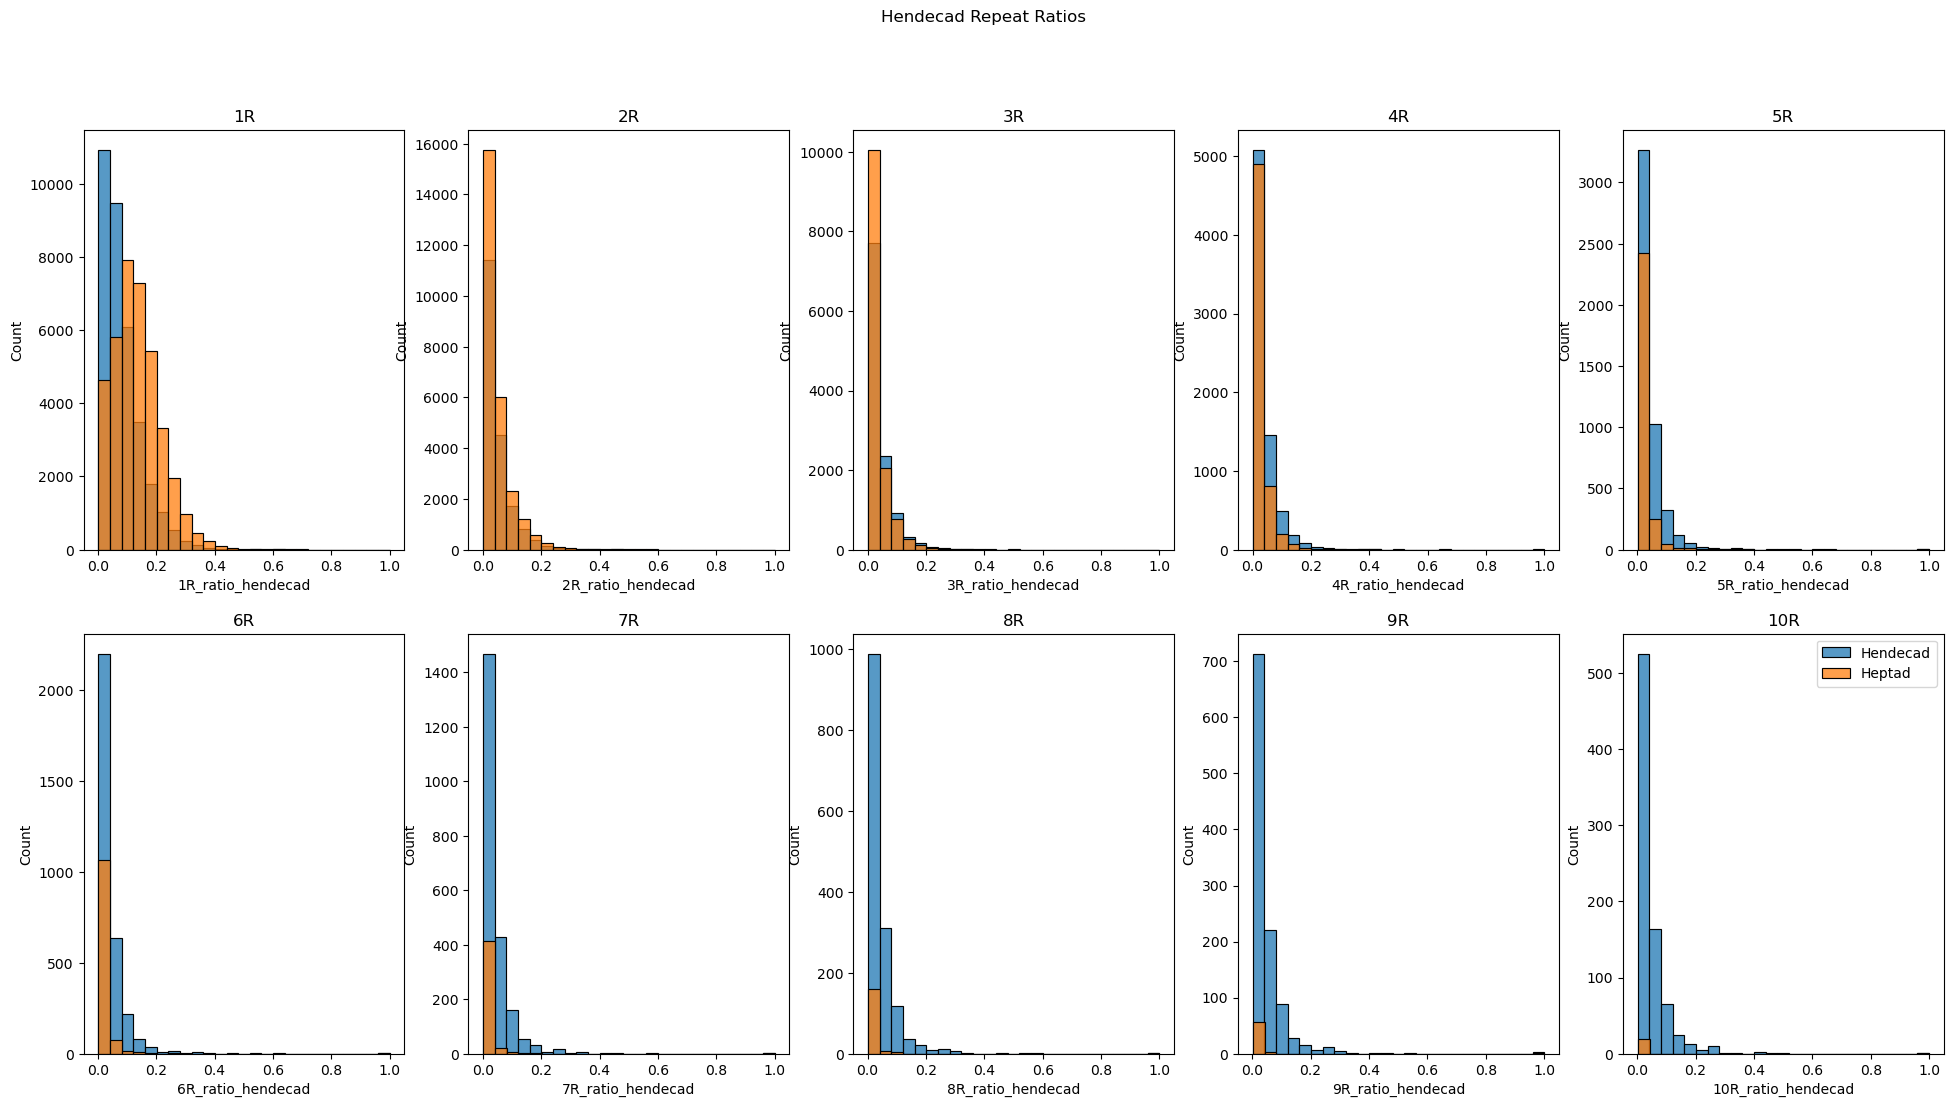

In [16]:
# Plot all xR ratios
fig, ax = plt.subplots(2, 5, figsize=(24, 12))

ix = 0
for i in range(2):
    for j in range(5):
        n = R[ix]
        ix += 1

        sns.histplot(df[df[f'{n}R_ratio_hendecad'] > 0][f'{n}R_ratio_hendecad'], bins=25, ax=ax[i, j], label='Hendecad')
        sns.histplot(df[df[f'{n}R_ratio_heptad'] > 0][f'{n}R_ratio_heptad'], bins=25, ax=ax[i, j], label='Heptad')

        ax[i, j].set_title(f'{n}R')

ax[i, j].legend()
fig.suptitle('Hendecad Repeat Ratios')
plt.show()

### Sankey

In [17]:
values = []

groups_r = []
groups_not_r = []

first = True

for i in R[:10]:
  
    if first:
        r = df[(df[f'{i}R_hendecad'] > 0)]       # where there is at least one pattern match
        not_r = df[(df[f'{i}R_hendecad'] == 0)]  # where there is no pattern match

        groups_r.append(r)

        values.append(len(r))  
        values.append(len(not_r))    
        
        first = False
    else:
        r = df[df[f'{i}R_hendecad'] > 0]                                 # where there is at least one pattern match
        not_r = df[(df[f'{i-1}R_hendecad'] > 0) & (df[f'{i}R_hendecad'] == 0)]    # where there is a pattern match in the previous iteration but not in the current

        groups_r.append(r)

        values.append(len(r))
        values.append(len(not_r))

In [18]:
labels = [[f'{i}R_hendecad', f'not {i}R_hendecad']for i in R]
labels = [item for sublist in labels for item in sublist]

color = ['#0f6349'] * len(labels)

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=["All"] + labels,
                color=color,
            ),
            link=dict(
                source=[0, 0, 1, 1, 3, 3, 5],  # , 5, 7, 7, 9, 9, 11, 11, 13, 13, 15, 15, 17, 17],
                target=[1, 2, 3, 4, 5, 6, 7],  # , 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                value=values,
            ),
        )
    ]
)

# i = 0
# for l, v in zip(['All'] + labels, values):
#     print(f'{i} : {l} : {v}')
#     i += 1

fig.show()

### Pie Charts

In [19]:
# display all pie charts from groups_r 
top_n = 5

for ix, group in enumerate(groups_r[:10]):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].hist(group['stretch_seq'].apply(lambda x: len(x)), bins=100, edgecolor='black')
    ax[1].pie(group['group_ix'].value_counts()[:top_n], labels=group['group_ix'].value_counts().index[:top_n], 
            explode=[0.1] + [0 for _ in range(len(group['group_ix'].unique()) - 1)][:top_n-1],
            wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-', 'antialiased': True})

    plt.title(f'R{ix+1}')
    plt.savefig(f'/home/enno/uni/SS24/thesis/01_data/seq_analysis/pie_charts/R{ix+1}_hendecad.png', bbox_inches='tight')
    plt.close()
    # plt.show()

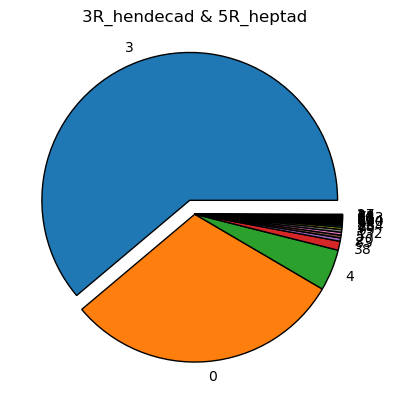

In [22]:
plt.pie(df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0]['group_ix'].value_counts(), labels=df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0]['group_ix'].value_counts().index,
        explode=[0.1] + [0 for _ in range(len(df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0]['group_ix'].unique()) - 1)],
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-', 'antialiased': True})
plt.title('3R_hendecad & 5R_heptad')
plt.show()

### Sequence Motifs for xR

In [23]:
df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0]

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,group_ix,1R_hendecad,1R_ratio_hendecad,1R_ix_hendecad,...,150R_ix_hendecad,150R_heptad,150R_ratio_heptad,150R_ix_heptad,168R_hendecad,168R_ratio_hendecad,168R_ix_hendecad,168R_heptad,168R_ratio_heptad,168R_ix_heptad
20,MBC7774458.1,MQTTVKQPENQANKTSTTKGNFFGGSGAAPFFQAKLTVNEPGDKYE...,"[1019, 1184]",eakrkeeekaknaswweraknaiksvvkaitaaidkvfnavrkfvk...,0.000438,group_1_0,4,22,0.141935,"[(18, 29), (22, 33), (25, 36), (26, 37), (29, ...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
121,MBP6837768.1,MDFLLKEKLGRLDLDHLKQRDPRTEEAQRKLEELGKQTLALIEQAG...,"[1344, 1488]",gfikrntvdrvadainwlgdqisaiadaisaawntltdfissalea...,0.000503,group_1_0,4,34,0.253731,"[(7, 18), (10, 21), (14, 25), (21, 32), (24, 3...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
141,WP_075688569.1,MADYTLSAKITGDASGFTRAFRSAADTVNQLSEKTKAAGEKISEFG...,"[443, 708]",fayqmakneafrnnvisvfnsikdkvmsvvqfltpifqniwatlqp...,0.000268,group_0,3,52,0.203922,"[(14, 25), (25, 36), (32, 43), (43, 54), (47, ...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
142,WP_075688569.1,MADYTLSAKITGDASGFTRAFRSAADTVNQLSEKTKAAGEKISEFG...,"[749, 924]",fvagiinaimaviapiivfvagviaaiidvirpivitvtgifntvf...,0.000412,group_0,3,39,0.236364,"[(1, 12), (2, 13), (4, 15), (5, 16), (8, 19), ...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
148,KAF9374479.1,MDTNVKHQAKKVIDTLYGWLFDGEGYTAPAPAGQCVKTYVDGDEVI...,"[1023, 1158]",lvkdaqavvqdaettvenavhsaetaaqeatrvakgtfnagiasaq...,0.000537,unassigned,0,18,0.144000,"[(1, 12), (4, 15), (8, 19), (15, 26), (19, 30)...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40425,WP_047933985.1,Misdlidalvgfisdligglvglitgiinalgelitgiinalitfl...,"[1, 77]",isdlidalvgfisdligglvglitgiinalgelitgiinalitflt...,0.001063,unassigned,0,22,0.333333,"[(0, 11), (4, 15), (8, 19), (11, 22), (15, 26)...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
40441,UKI16746.1,MITKAAITASAAASAAVGALAKEAIASFGDYEQLAGGAQLMFGEAY...,"[185, 461]",gyaqaegadtlqgsmasmtaawqnmltgmadptqdfdrlvsdlids...,0.000258,group_0,3,57,0.214286,"[(7, 18), (17, 28), (39, 50), (46, 57), (54, 6...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
40484,WP_173053923.1,Maatavlvagflaatavlvagflaatavlvagflaatavlvagfla...,"[1, 159]",aatavlvagflaatavlvagflaatavlvagflaatavlvagflaa...,0.000458,unassigned,0,46,0.310811,"[(0, 11), (3, 14), (4, 15), (7, 18), (11, 22),...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]
40525,KAH7396256.1,Maelledcadvtelledsaedvtllledladdvvlllediallved...,"[1, 114]",aelledcadvtelledsaedvtllledladdvvlllediallvedr...,0.000632,unassigned,0,20,0.194175,"[(0, 11), (17, 28), (20, 31), (24, 35), (28, 3...",...,[],0,0.0,[],0,0.0,[],0,0.0,[]


3.0


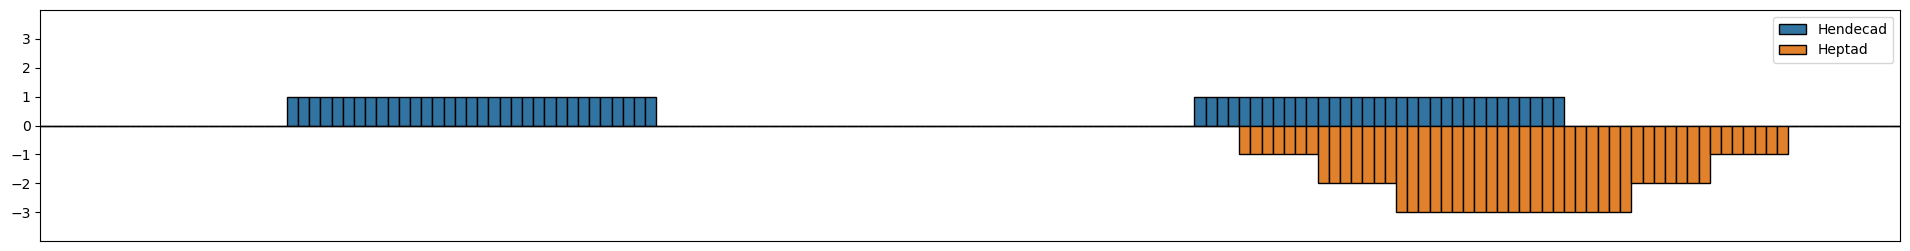

4.0


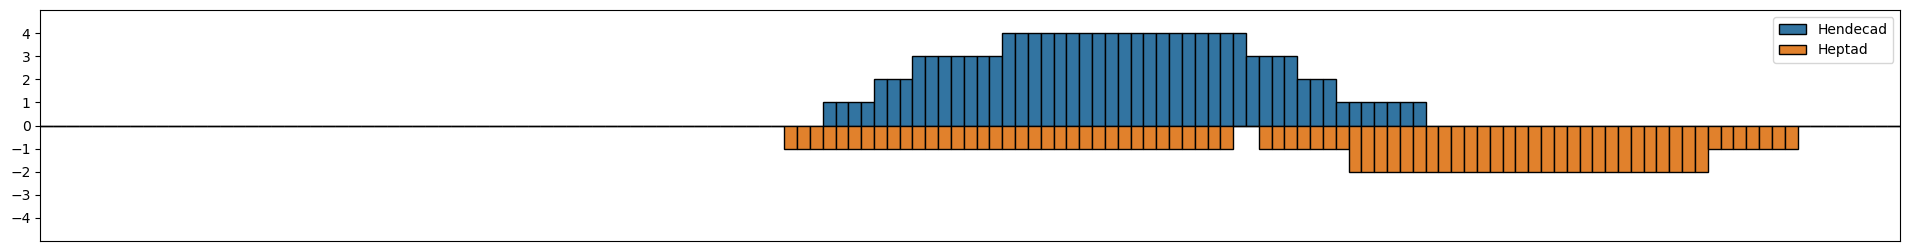

5.0


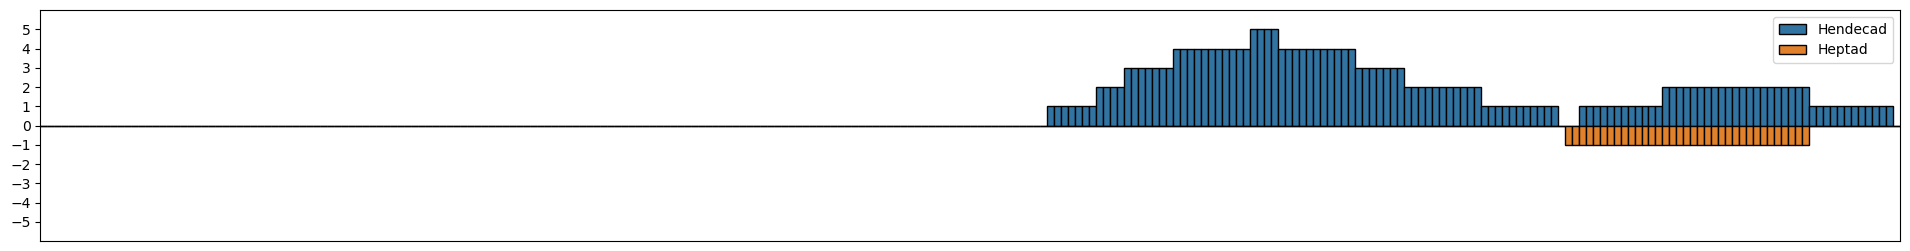

4.0


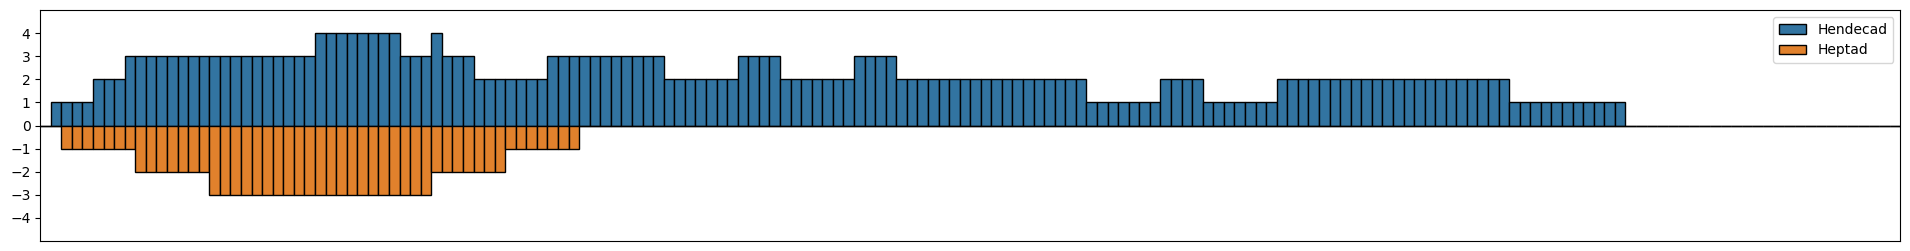

1.0


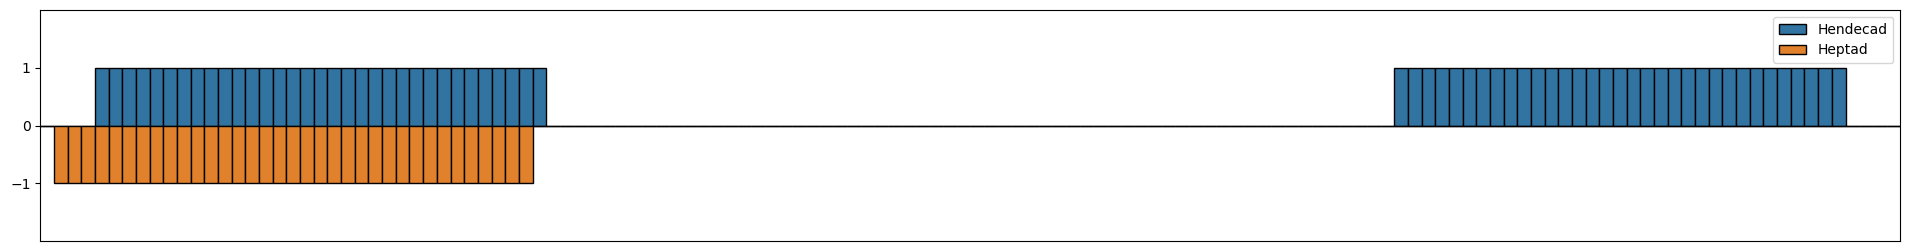

3.0


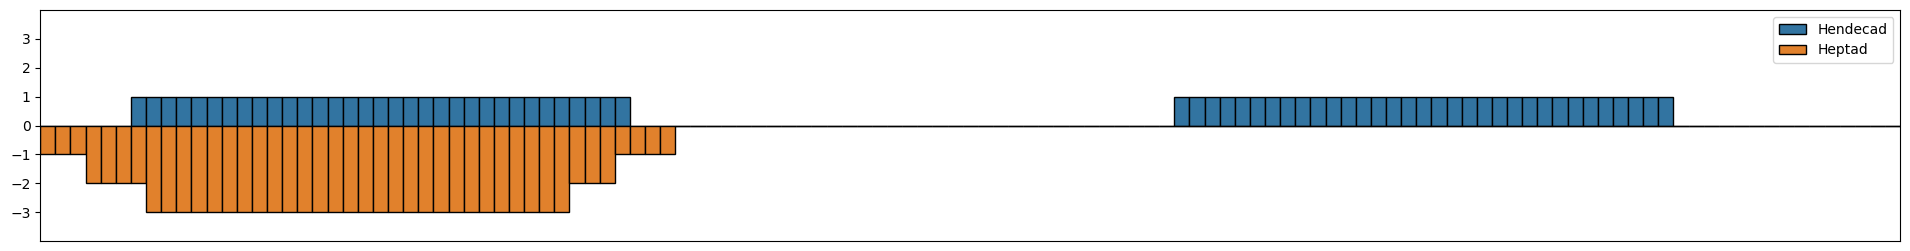

13.0


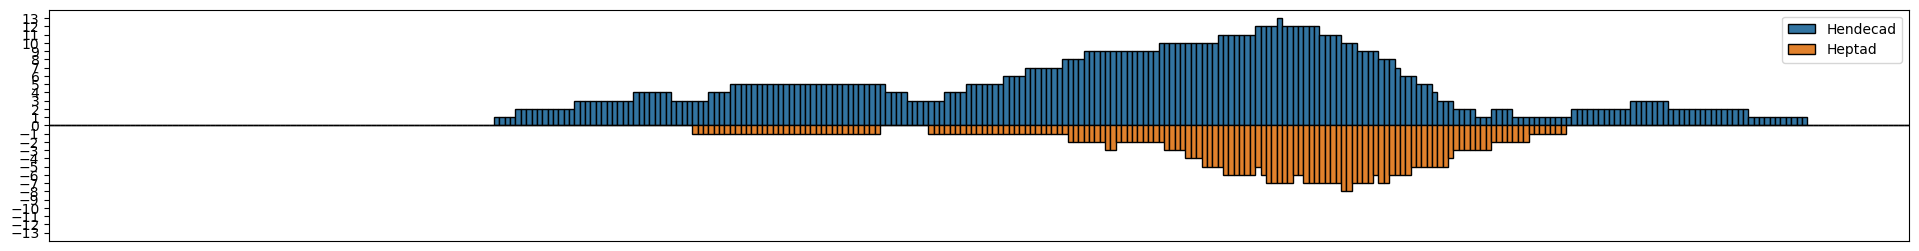

4.0


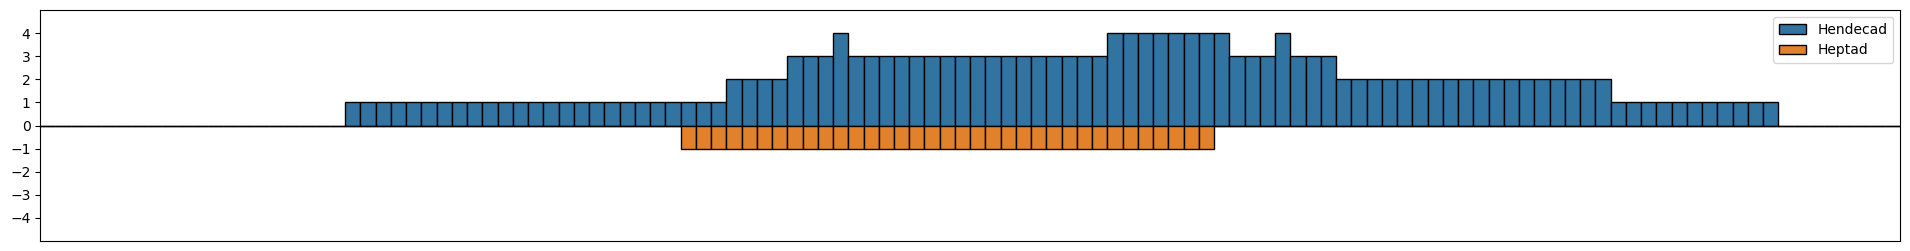

2.0


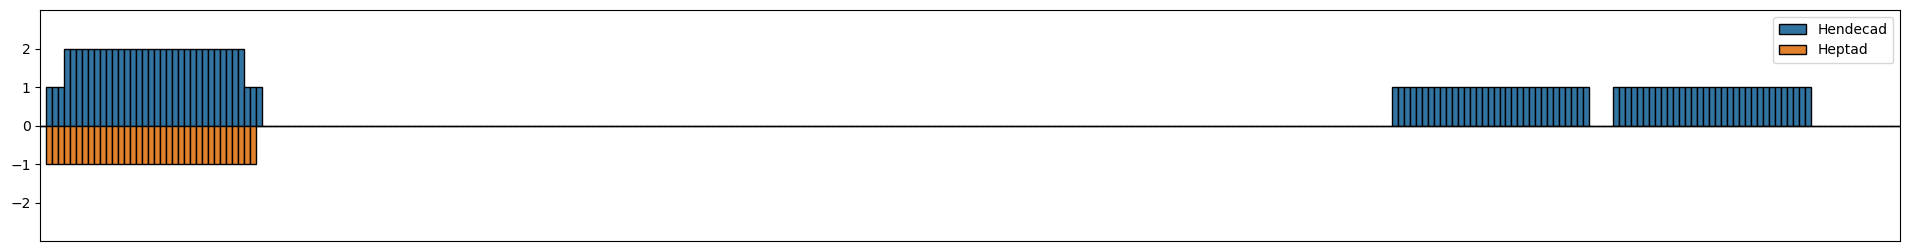

8.0


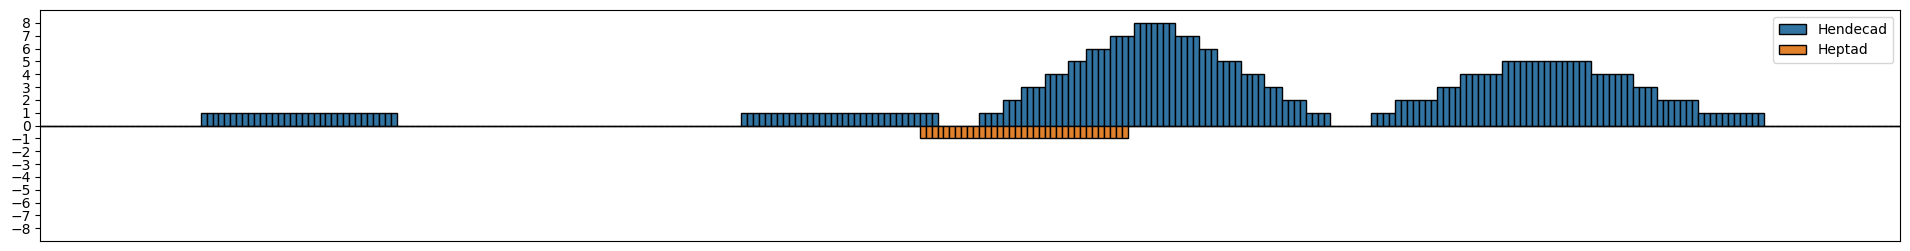

In [24]:
for i in range(10):
    test = df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0].iloc[i]
    # i = 1

    len_test = len(test['stretch_seq']) + 1

    tmp_hendecad = np.zeros(len_test)
    tmp_heptad = np.zeros(len_test)

    fig, ax = plt.subplots(figsize=(24, 3))

    for ix in test[f'{3}R_ix_hendecad']:
        tmp_hendecad[ix[0]:ix[1]] += 1

    for ix in test[f'{5}R_ix_heptad']:
        tmp_heptad[ix[0]:ix[1]] -= 1

    sns.barplot(x=np.arange(len_test), y=tmp_hendecad, label='Hendecad', color='#1f77b4', width=1, edgecolor='black')
    sns.barplot(x=np.arange(len_test), y=tmp_heptad, label='Heptad', color='#ff7f0e', width=1, edgecolor='black')    

    y_lim = max(abs(min(tmp_heptad)), max(tmp_hendecad))
    print(y_lim)
    plt.ylim(-y_lim-1, y_lim+1)
    plt.yticks(np.arange(-y_lim, y_lim+1))

    plt.xticks([])
    plt.legend()
    plt.show()


In [25]:
test = df.iloc[40194]
i = 2

len_test = len(test['stretch_seq'])

tmp = np.zeros(len_test)

repeat_seq = [Seq(test['stretch_seq'][ix[0]:ix[1]].upper()) for ix in test[f'{i}R_ix_hendecad']]

repeat_seq

m = motifs.create(repeat_seq, alphabet=''.join(amino_acids))

motif = ''

M = []
for k, v in m.counts.items():
    M.append(v)

M = np.array(M)
M = M / M.sum(axis=0)

for i in range(M.shape[1]):
    max_aa_value = np.max(M[:, i])
    max_aa_ix = np.argmax(M[:, i])
    max_aa = list(m.counts.keys())[max_aa_ix]

    if max_aa_value > 0.3:
        motif += max_aa
    else:
        motif += '*'

motif

'V**I***I***V**II**VI**'

### CLANS on 10R

In [26]:
tmp_df = df[df['group_id'] == 'unassigned'].reset_index(drop=True)


with open(f'/home/enno/uni/SS24/thesis/01_data/seq_analysis/xR_fasta/unassigned.fasta', 'w') as f:
    for i in range(len(tmp_df)):
        f.write(f'>{tmp_df.loc[i, "id"]}\n')
        f.write(f'{tmp_df.loc[i, "seq"]}\n')

In [27]:
# clans_10r = '/ebio/abt1_share/prediction_hendecads/0_data/npf_data/xR_fasta/10R_large_cluster.txt'

# with open(clans_10r, 'r') as f:
#     lines = f.readlines()

# lines = [line.strip()[:-4] for line in lines]

### UMAP

In [28]:
col = [x for x in df.columns if 'ratio' in x]

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

embedding = reducer.fit_transform(df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0][col])

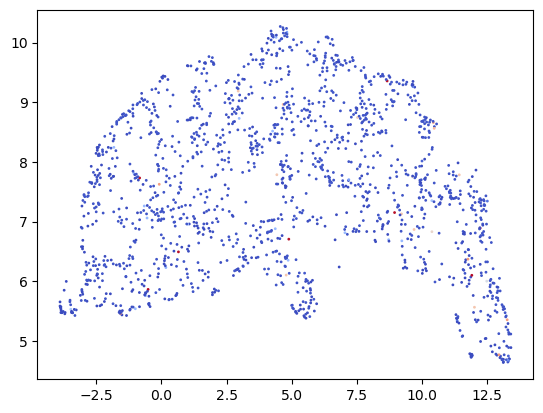

In [29]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=df[(df['3R_hendecad'] > 0) & df['5R_heptad'] > 0]['group_ix'], s=1, cmap='coolwarm')
plt.show()

## Sequence Properties

In [30]:
# compute amino acid frequency for all groups

repeat_numbers_hendecad = [f'{i}R_ratio_hendecad' for i in R]
repeat_numbers_heptad = [f'{i}R_ratio_heptad' for i in R]

total_aa_freq = {aa: 0 for aa in amino_acids}
total = 0

property_df = pd.DataFrame(columns=['group'] +  
                                    amino_acids +
                                    repeat_numbers_hendecad +
                                    repeat_numbers_heptad +
                                    ['mean_length'])

groups = df['group_id'].unique()
for group in groups:
    group_df = df[df['group_id'] == group].reset_index(drop=True)
    
    aa_freq = {aa: 0 for aa in amino_acids}
    total = 0

    for seq in group_df['stretch_seq']:
        for aa in seq:
            aa_freq[aa.upper()] += 1
            total += 1

    aa_freq = {aa: freq/total for aa, freq in aa_freq.items()}
    
    mean_length = group_df['stretch_seq'].apply(lambda x: len(x)).mean()
    
    r_freq_hendecad = {f'{i}R_ratio_hendecad': group_df[f'{i}R_ratio_hendecad'].mean() for i in R}
    r_freq_heptad = {f'{i}R_ratio_heptad': group_df[f'{i}R_ratio_heptad'].mean() for i in R}
    
    property_df.loc[len(property_df)] = {'group': group, **aa_freq, **r_freq_hendecad, **r_freq_heptad, 'mean_length': mean_length}

In [31]:
property_df.head()

,group,A,C,D,E,F,G,H,I,K,...,8R_ratio_heptad,9R_ratio_heptad,10R_ratio_heptad,25R_ratio_heptad,50R_ratio_heptad,75R_ratio_heptad,100R_ratio_heptad,150R_ratio_heptad,168R_ratio_heptad,mean_length
0,unassigned,0.123723,0.008173,0.059755,0.092798,0.020785,0.066104,0.019502,0.032454,0.070289,...,0.000079,0.000052,0.000043,0.000038,0.000038,0.000038,0.0,0.0,0.0,153.270665
1,group_42,0.121358,0.004806,0.042055,0.069691,0.014419,0.049564,0.026434,0.043557,0.029438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,114.793103
2,group_38,0.246801,0.000000,0.059519,0.085886,0.008918,0.077549,0.019387,0.013765,0.069213,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,161.187500
3,group_0,0.105091,0.001750,0.040017,0.038803,0.047893,0.086149,0.004022,0.109629,0.055793,...,0.000248,0.000067,0.000016,0.000000,0.000000,0.000000,0.0,0.0,0.0,209.047855
4,group_1_0,0.153089,0.001720,0.062651,0.059756,0.031894,0.082124,0.008660,0.060263,0.067587,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,154.844828


<Axes: >

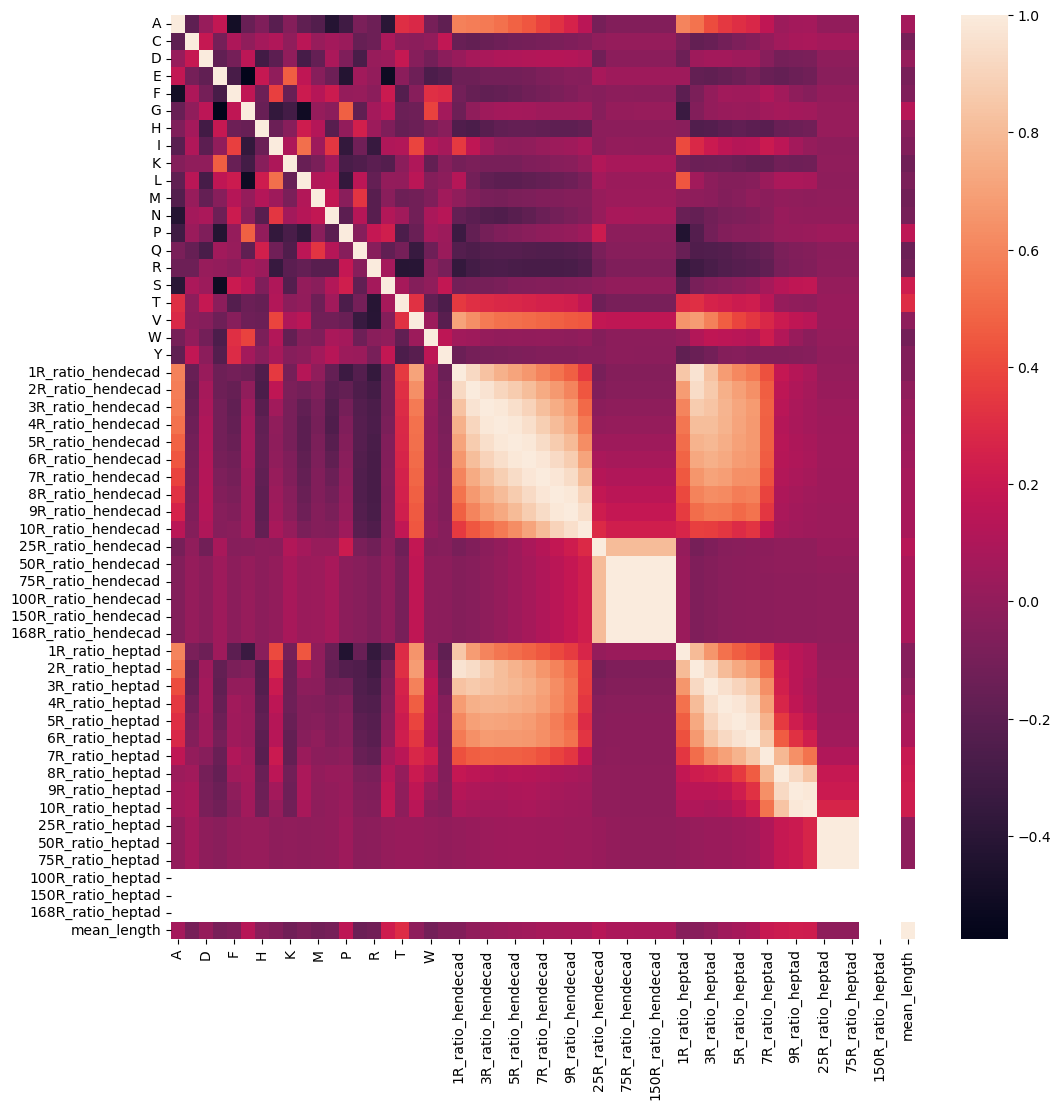

In [32]:
plt.figure(figsize=(12, 12))
sns.heatmap(property_df.drop(columns=['group']).corr())

In [33]:
property_df

,group,A,C,D,E,F,G,H,I,K,...,8R_ratio_heptad,9R_ratio_heptad,10R_ratio_heptad,25R_ratio_heptad,50R_ratio_heptad,75R_ratio_heptad,100R_ratio_heptad,150R_ratio_heptad,168R_ratio_heptad,mean_length
0,unassigned,0.123723,0.008173,0.059755,0.092798,0.020785,0.066104,0.019502,0.032454,0.070289,...,0.000079,0.000052,0.000043,0.000038,0.000038,0.000038,0.0,0.0,0.0,153.270665
1,group_42,0.121358,0.004806,0.042055,0.069691,0.014419,0.049564,0.026434,0.043557,0.029438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,114.793103
2,group_38,0.246801,0.000000,0.059519,0.085886,0.008918,0.077549,0.019387,0.013765,0.069213,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,161.187500
3,group_0,0.105091,0.001750,0.040017,0.038803,0.047893,0.086149,0.004022,0.109629,0.055793,...,0.000248,0.000067,0.000016,0.000000,0.000000,0.000000,0.0,0.0,0.0,209.047855
4,group_1_0,0.153089,0.001720,0.062651,0.059756,0.031894,0.082124,0.008660,0.060263,0.067587,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,154.844828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,group_101,0.096868,0.000000,0.057425,0.078306,0.020882,0.064965,0.009861,0.050464,0.053944,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,123.142857
134,group_131,0.178557,0.008866,0.037938,0.051134,0.009691,0.086186,0.001237,0.031959,0.011546,...,0.000298,0.000225,0.000152,0.000000,0.000000,0.000000,0.0,0.0,0.0,303.125000
135,group_83,0.170957,0.003885,0.051481,0.121904,0.007285,0.018941,0.007771,0.061680,0.079165,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,137.266667
136,group_50,0.051245,0.005501,0.085698,0.098147,0.023162,0.027794,0.013897,0.051824,0.075854,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,123.357143


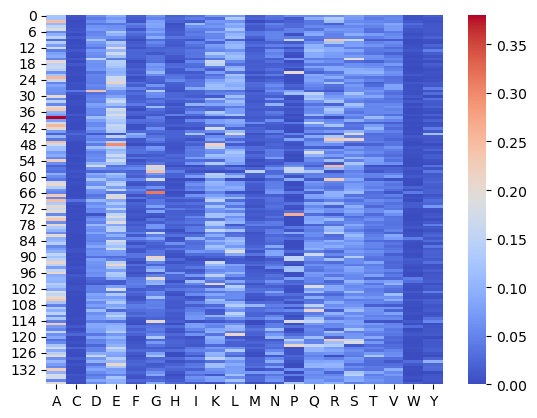

In [34]:
sns.heatmap(property_df[amino_acids], cmap='coolwarm')

plt.show()

## PT5

In [35]:
from transformers import T5Tokenizer, T5EncoderModel
import torch
import re

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)

In [ ]:
# only GPUs support half-precision currently; if you want to run on CPU use full-precision (not recommended, much slower)
model.to(torch.float32) if device==torch.device("cpu") else model.half()

# randomly sample 1k sequences from the dataset
seq_ex_df = df.sample(1000)
sequence_examples = seq_ex_df['seq']
sequence_groups = seq_ex_df['group_ix']

# replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequence_examples]

In [ ]:
# tokenize sequences and pad up to the longest sequence in the batch
ids = tokenizer(sequence_examples, add_special_tokens=True, padding="longest")

input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

In [ ]:
# generate embeddings
with torch.no_grad():
    embedding_repr = model(input_ids=input_ids, attention_mask=attention_mask)

: 

In [ ]:
X = embedding_repr.last_hidden_state.mean(dim=1)
X.shape

torch.Size([2000, 1024])

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

embedding = reducer.fit_transform(X)

ValueError: 'c' argument has 40590 elements, which is inconsistent with 'x' and 'y' with size 2000.

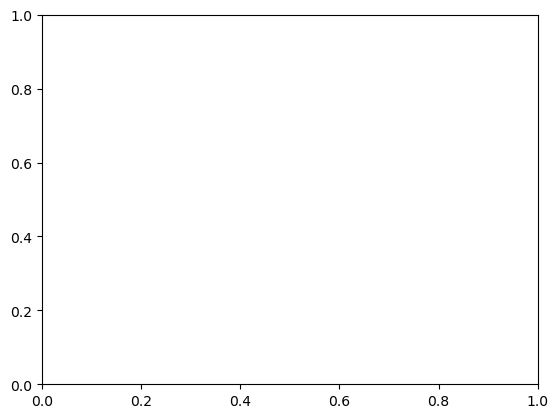

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, c=df['group_ix'], cmap='coolwarm')